# Siamese with contrastive loss & euclidean distance

siamese transfer learning

Source: https://github.com/keras-team/keras/blob/master/examples/mnist_siamese.py

Other source:
1. https://github.com/bukhari-utp/Siamese-Networks-for-One-Shot-Learning (pair of images)
2. https://github.com/bukhari-utp/Siamese-Networks
3. https://github.com/bukhari-utp/siamese-transfer-learning

It follows Hadsell-et-al.'06 [1] by computing the Euclidean distance on the
output of the shared network and by optimizing the contrastive loss (see paper
for mode details).

References

- Dimensionality Reduction by Learning an Invariant Mapping
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf


level of idea:
1. Dimensionality Reduction by Learning an Invariant Mapping
2. DeepFace: Closing the Gap to Human-Level Performance in Face Verification
3. (proposed) DeepDR: High Fidelity DR detection with Triplet Loss, using InceptionV4 

#### TO DO:
- [ ] stratified split 10/30/50 % dataset
- [ ] Plot training grpah (see: siamese-transfer-learning/siamese_dogs_vs_cats_vgg16.ipynb)

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="4"

In [2]:
from __future__ import absolute_import
from __future__ import print_function
import numpy as np

import random
from keras.datasets import mnist
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Input, Flatten, Dense, Dropout, Lambda, Conv2D, MaxPooling2D, Activation, BatchNormalization
from keras.optimizers import RMSprop, SGD
from keras import backend as K
from keras.utils.np_utils import to_categorical
from keras.utils.multi_gpu_utils import multi_gpu_model
from keras.regularizers import l2, l1
from keras.utils import plot_model
from keras import backend as K
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

from sklearn.model_selection import train_test_split

from tensorflow.python.client import device_lib

from IPython.display import Image as image_disp

import pandas as pd
import os
from PIL import Image

Using TensorFlow backend.


In [3]:
## Restrict GPU memory usage
import tensorflow as tf
config = tf.ConfigProto()
from keras.backend.tensorflow_backend import set_session
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True 
set_session(tf.Session(config=config))

In [4]:
# Check whether GPU is being or not
#print(device_lib.list_local_devices())

In [5]:
OUT_DIR = '../output/DR-Net_contrastive_loss'
if not os.path.exists(OUT_DIR):
    os.mkdir('../output/DR-Net_contrastive_loss')

CHECKPOINTED_WEIGHTS = os.path.join(OUT_DIR, 'best_checkpointed_weights.hdf5')

In [6]:
num_classes = 10

def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))

def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    sqaure_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * sqaure_pred + (1 - y_true) * margin_square)

def create_pairs(x, digit_indices):
    '''Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''
    pairs = []
    labels = []
    n = min([len(digit_indices[d]) for d in range(num_classes)]) - 1
    for d in range(num_classes):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            pairs += [[x[z1], x[z2]]]
            inc = random.randrange(1, num_classes)
            dn = (d + inc) % num_classes
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]  # 1=same class, 0=different class
    return np.array(pairs), np.array(labels)

def create_base_network(input_shape):
    '''Base network to be shared (eq. to feature extraction).
    source: https://riptutorial.com/keras/example/32608/transfer-learning-using-keras-and-vgg
    '''
    
    input = Input(shape=input_shape)
    x = Flatten()(input)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(128, activation='relu')(x)
    """
    
    vgg16 = VGG16(weights=None, include_top=False, input_shape = input_shape)  # input_shape=(224,224,3)

    # Creating dictionary that maps layer names to the layers
    layer_dict = dict([(layer.name, layer) for layer in vgg16.layers])

    # Getting output tensor of the last VGG layer that we want to include
    x = layer_dict['block2_pool'].output  # block2_pool: 128, block3_pool:256, block5_pool:512

    # Stacking a new simple convolutional network on top of it  
    x = Conv2D(filters=64, kernel_size=(3, 3), activation='relu')(x)  # very important, to reduce parameters number
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu', name='dense_128')(x)  # x = Dense(128, kernel_regularizer = l2(0.5))(x)
    """
    return Model(input, x, name='base_net')  # Model(vgg16.input, x, name='base_net')

def dense_relu_bn_dropout(x, size, dropout, alpha = 0.1, reg = 0):
    """dense, relu, batch normalization, dropout
    """
    x = Dense(size, kernel_regularizer = l2(reg))(x)
    x = Activation('tanh')(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout)(x)
    return x

def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)

def accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))

In [7]:
#width, height = 224, 224
mode = 'RGB'

def get_image(image_path, width, height, mode):
    image = Image.open(image_path)
    image = image.resize([width, height], Image.BILINEAR)
    return np.array(image.convert(mode))

def load_data():  # MESSIDOR dataset
    base_image_dir = '../data/MESSIDOR_patches'
    retina_df = pd.read_csv(os.path.join(base_image_dir, 'messidor_labels.csv'))
    retina_df['level'] = retina_df['level'].map(lambda x: 0 if x == 0 else 1)
    retina_df['PatientId'] = retina_df['image'] #map(lambda x: x.split('_')[0])
    retina_df['path'] = retina_df['image'].map(lambda x: os.path.join(base_image_dir, '{}.jpg'.format(x)))
    retina_df['exists'] = retina_df['path'].map(os.path.exists)
    retina_df['level_cat'] = retina_df['level'].map(lambda x: to_categorical(x, 1+retina_df['level'].max()))

    retina_df.dropna(inplace=True)  # Remove missing values.
    retina_df = retina_df[retina_df['exists']]

    rr_df = retina_df[['PatientId', 'level']].drop_duplicates()  # X=PatientId, y=level2
    train_ids, valid_ids = train_test_split(rr_df['PatientId'], test_size=0.25, random_state=2018, stratify=rr_df['level'])

    train_df = retina_df[retina_df['PatientId'].isin(train_ids)]   
    valid_df = retina_df[retina_df['PatientId'].isin(valid_ids)]

    X_train = np.array([get_image(sample_file, width, height, mode) for sample_file in train_df['path']])
    y_train = np.array(train_df['level'])
    X_test = np.array([get_image(sample_file, width, height, mode) for sample_file in valid_df['path']])
    y_test = np.array(valid_df['level'])
    
    return (X_train, y_train), (X_test, y_test)

In [8]:
# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()
#(x_train, y_train), (x_test, y_test) = load_data()  # MESSIDOR dataset
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [9]:
x_train.shape, x_test.shape

((60000, 28, 28), (10000, 28, 28))

In [11]:
x_train_res, x_train, y_train_res, y_train = train_test_split(x_train, y_train, test_size=0.10, random_state=2018, stratify=y_train)
x_train_res.shape, y_train_res.shape, x_train.shape, y_train.shape

((54000, 28, 28), (54000,), (6000, 28, 28), (6000,))

## Train siamese 

In [12]:
# create training+test positive and negative pairs
digit_indices = [np.where(y_train == i)[0] for i in range(num_classes)]
tr_pairs, tr_y = create_pairs(x_train, digit_indices)

digit_indices = [np.where(y_test == i)[0] for i in range(num_classes)]
te_pairs, te_y = create_pairs(x_test, digit_indices)

In [13]:
input_shape = x_train.shape[1:] # (224,224,3)
# network definition
base_network = create_base_network(input_shape)

input_a = Input(shape=input_shape, name='input_a')
input_b = Input(shape=input_shape, name='input_b')

# because we re-use the same instance `base_network`,
# the weights of the network will be shared across the two branches
processed_a = base_network(input_a)
processed_b = base_network(input_b)
#processed_c = base_network(input_c)

distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape, name='euc_dist')([processed_a, processed_b])
# in 'siamese_dogs_vs_cats_vgg16', it used cos distance with sigmoid

# To avoid OOM errors, this model could have been built on CPU
import tensorflow as tf
with tf.device('/cpu:0'):
    siamese_net = Model([input_a, input_b], distance)

In [14]:
siamese_net.summary()
MODEL_IMAGE = os.path.join(OUT_DIR, 'siamese_contrastive_loss.png')
plot_model(siamese_net, to_file=MODEL_IMAGE, show_shapes=True)
#image_disp(filename=MODEL_IMAGE)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_a (InputLayer)            (None, 28, 28)       0                                            
__________________________________________________________________________________________________
input_b (InputLayer)            (None, 28, 28)       0                                            
__________________________________________________________________________________________________
base_net (Model)                (None, 128)          133504      input_a[0][0]                    
                                                                 input_b[0][0]                    
__________________________________________________________________________________________________
euc_dist (Lambda)               (None, 1)            0           base_net[1][0]                   
          

In [15]:
# train
BATCH_SIZE = 32 #128 (OOM)
epochs = 10  # 20
rms = RMSprop()
reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5,
              patience=5, verbose = 1, min_lr=1e-8)
early_stopping = EarlyStopping(monitor='val_acc',
                              min_delta=1e-4,
                              patience=25,
                              verbose=0, mode='auto')
checkpointer = ModelCheckpoint(filepath=CHECKPOINTED_WEIGHTS, verbose=1, save_best_only=True, monitor='val_accuracy')
callback_list = [checkpointer]

#siamese_net = multi_gpu_model(siamese_net, gpus=4)  # multi-gpu
siamese_net.compile(loss=contrastive_loss, optimizer=rms, metrics=[accuracy])
siamese_net.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_y,
                validation_split=.33,
                batch_size=BATCH_SIZE,
                epochs=epochs,
                validation_data=([te_pairs[:, 0], te_pairs[:, 1]], te_y),
                callbacks=callback_list)
# in 'siamese_dogs_vs_cats_vgg16' it has history

Train on 10820 samples, validate on 17820 samples
Epoch 1/10
10820/10820 [==============================] - 2s 199us/step - loss: 0.1781 - accuracy: 0.7415 - val_loss: 0.1085 - val_accuracy: 0.8626

Epoch 00001: val_accuracy improved from -inf to 0.86263, saving model to ../output/DR-Net_contrastive_loss/best_checkpointed_weights.hdf5
Epoch 2/10
10820/10820 [==============================] - 2s 152us/step - loss: 0.1060 - accuracy: 0.8748 - val_loss: 0.0836 - val_accuracy: 0.9014

Epoch 00002: val_accuracy improved from 0.86263 to 0.90140, saving model to ../output/DR-Net_contrastive_loss/best_checkpointed_weights.hdf5
Epoch 3/10
10820/10820 [==============================] - 2s 162us/step - loss: 0.0771 - accuracy: 0.9202 - val_loss: 0.0742 - val_accuracy: 0.9163

Epoch 00003: val_accuracy improved from 0.90140 to 0.91633, saving model to ../output/DR-Net_contrastive_loss/best_checkpointed_weights.hdf5
Epoch 4/10
10820/10820 [==============================] - 2s 159us/step - loss: 0.0

In [16]:
# compute final accuracy on training and test sets
y_pred = siamese_net.predict([tr_pairs[:, 0], tr_pairs[:, 1]])
tr_acc = compute_accuracy(tr_y, y_pred)
y_pred = siamese_net.predict([te_pairs[:, 0], te_pairs[:, 1]])
te_acc = compute_accuracy(te_y, y_pred)

print('* Accuracy on training set: %0.2f%%' % (100 * tr_acc))
print('* Accuracy on test set: %0.2f%%' % (100 * te_acc))

* Accuracy on training set: 98.81%
* Accuracy on test set: 93.97%


## Train 'trained_based_net' to classify DR 
- Clear all
- save previous weight
- load previous weight
- do network surgery
- freeze

In [17]:
#from IPython.display import display_html
#def restartkernel() :
#    display_html("<script>Jupyter.notebook.kernel.restart()</script>",raw=True)

In [18]:
#restartkernel()

In [19]:
# Initialize siamese network
# input_shape = (224,224,3)
# network definition
base_network = create_base_network(input_shape)

input_a = Input(shape=input_shape, name='input_a')
input_b = Input(shape=input_shape, name='input_b')

# because we re-use the same instance `base_network`,
# the weights of the network will be shared across the two branches
processed_a = base_network(input_a)
processed_b = base_network(input_b)

distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape, name='euc_dist')([processed_a, processed_b])
# in 'siamese_dogs_vs_cats_vgg16', it used cos distance with sigmoid

# To avoid OOM errors, this model could have been built on CPU
import tensorflow as tf
with tf.device('/cpu:0'):
    siamese_net = Model([input_a, input_b], distance)
    
# siamese_net.load_weights(CHECKPOINTED_WEIGHTS)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 28)            0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               100480    
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               16512     
__________

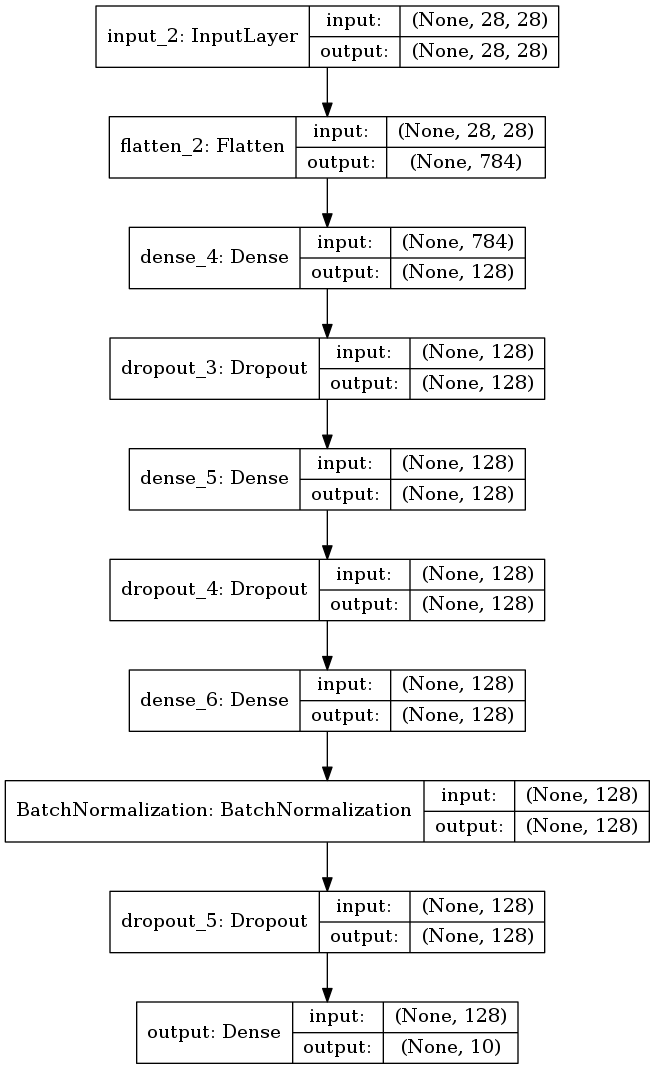

In [20]:
# Siamese Network surgery

layer_dict = dict([(layer.name, layer) for layer in siamese_net.layers])
# for key in layer_dict: print(key)

for layer in layer_dict['base_net'].layers:
    layer.trainable = True  # TODO: Transfer Learning = False, All layer Learning = True

inputs = layer_dict['base_net'].get_input_at(0)  # layer_dict['base_net'].get_input_at(0)

x = layer_dict['base_net'].get_output_at(0)
x = BatchNormalization(name='BatchNormalization')(x)
x = Dropout(0.5)(x)
x = Dense(num_classes, activation='softmax', name='output')(x)

with tf.device('/cpu:0'):
    trained_based_net = Model(inputs=inputs, outputs = x)

trained_based_net.summary()

MODEL_IMAGE = os.path.join(OUT_DIR, 'trained_based_net.png')
plot_model(trained_based_net, to_file=MODEL_IMAGE, show_shapes=True)
image_disp(filename=MODEL_IMAGE)

In [21]:
# train
BATCH_SIZE = 32 #128 (OOM)
epochs = 20
rms = RMSprop()
sgd = SGD()
#trained_based_net = multi_gpu_model(trained_based_net, gpus=4)  # multi-gpu
trained_based_net.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
trained_based_net.fit(x_train, to_categorical(y_train, 1+y_train.max()),
                      batch_size=BATCH_SIZE,
                      epochs=epochs,
                      validation_data=(x_test, to_categorical(y_test,1+y_test.max())))

Train on 6000 samples, validate on 10000 samples
Epoch 1/20
6000/6000 [==============================] - 2s 259us/step - loss: 1.3580 - acc: 0.5608 - val_loss: 0.4704 - val_acc: 0.8623
Epoch 2/20
6000/6000 [==============================] - 1s 160us/step - loss: 0.6617 - acc: 0.7928 - val_loss: 0.3717 - val_acc: 0.8900
Epoch 3/20
6000/6000 [==============================] - 1s 159us/step - loss: 0.5129 - acc: 0.8467 - val_loss: 0.3231 - val_acc: 0.9064
Epoch 4/20
6000/6000 [==============================] - 1s 157us/step - loss: 0.4371 - acc: 0.8662 - val_loss: 0.2850 - val_acc: 0.9149
Epoch 5/20
6000/6000 [==============================] - 1s 157us/step - loss: 0.3763 - acc: 0.8905 - val_loss: 0.2708 - val_acc: 0.9197
Epoch 6/20
6000/6000 [==============================] - 1s 168us/step - loss: 0.3346 - acc: 0.8993 - val_loss: 0.2691 - val_acc: 0.9181
Epoch 7/20
6000/6000 [==============================] - 1s 172us/step - loss: 0.2934 - acc: 0.9160 - val_loss: 0.2338 - val_acc: 0.9285

In [22]:
print(trained_based_net.evaluate(x_train, to_categorical(y_train, 1+y_train.max())))
print(trained_based_net.evaluate(x_test, to_categorical(y_test, 1+y_test.max())))

6000/6000 [==============================] - 0s 34us/step
[0.02687243561446667, 0.9943333333333333]
10000/10000 [==============================] - 0s 35us/step
[0.19497653886070476, 0.9435]
